In [1]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from skopt import BayesSearchCV
import pandas as pd
from sklearn.metrics import precision_recall_curve, auc, roc_curve, confusion_matrix, f1_score, roc_auc_score
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.model_selection import GroupKFold

In [2]:
matrix = pd.read_csv('/home/jsearle/bigDrive/NAX/NLP-SAH_identification/featureMatrix/2_keyword_matrix.csv', index_col=0)
y_data = matrix[['BDSPPatientID', 'NoteTitle', 'annot']]
X = matrix[['ICD']]
X.head()

,ICD
0,0
1,0
2,0
3,0
4,0


In [3]:
y = y_data['annot']
y.head()

0    0
1    0
2    0
3    0
4    0
Name: annot, dtype: int64

In [4]:
all_predictions = []
all_true_labels = []
all_row_numbers = []

# outer loop
auc_cv = []
auc_pr = []
f1_cv = []
cf_cv = []
final_Cs = []
final_l1 = []
predictions = []
roc_curves = []
pr_curves = []

# Dictionary to store feature importances
feature_importances_dict = {feature: [] for feature in X.columns}

# Initialize KFold
gkf = GroupKFold(n_splits=5)

for train_index, test_index in gkf.split(X,y,groups=y_data['BDSPPatientID']):
    Xtr, Xte = X.loc[train_index], X.loc[test_index]
    ytr, yte = y.loc[train_index], y.loc[test_index]

   
    model = LogisticRegression(
            penalty='elasticnet',
            class_weight=None, random_state=2023,
            solver='saga', max_iter=10000)
   
    search_spaces = {
         'C': (1e-2, 1e+2, 'log-uniform'),
         'l1_ratio': (0.01, 0.99),
    }
    model_cv = BayesSearchCV(model,
            search_spaces,
            n_iter=50, scoring='roc_auc', n_jobs=15,
            cv=5, random_state=2023)
    model_cv.fit(Xtr, ytr)

    #Find the Best hyperparameters and append them
    best_hparams = model_cv.best_params_
    best_C = best_hparams['C']
    best_l1_ratio = best_hparams['l1_ratio']
    final_Cs.append(best_C)
    final_l1.append(best_l1_ratio)

    model = model_cv.best_estimator_

    ytr_pred = model.predict_proba(Xtr)[:,1]      # Xtr is training features, ytr is training labels, ytr_pred is training predictions = Prob(y=1|Xtr)
    yte_pred = model.predict_proba(Xte)[:,1]    # Xte is testing features

    fpr, tpr, cutoffs = roc_curve(yte, yte_pred)
    best_cutoff = cutoffs[np.argmax(tpr - fpr)]
    yte_pred_bin =(yte_pred>best_cutoff).astype(int)
    auc_cv.append(roc_auc_score(yte, yte_pred))
    f1_cv.append( f1_score(yte, yte_pred_bin) )
    cf_cv.append( confusion_matrix(yte, yte_pred_bin) )
    predictions.append(yte_pred_bin)

    # Store the predictions and true labels for this fold
    all_predictions.extend(yte_pred_bin)
    all_true_labels.extend(yte)
    all_row_numbers.extend(y_data.iloc[test_index]['BDSPPatientID'])

    # Save info for the plots
    roc_curves.append((fpr, tpr, roc_auc_score(yte, yte_pred)))
    precision, recall, thresholds = precision_recall_curve(yte, yte_pred)
    pr_curves.append((recall, precision, auc(recall, precision)))
    auc_pr_loop = auc(recall, precision)
    auc_pr.append(auc_pr_loop)

    # Extract feature importances (coefficients)
    feature_importances = model.coef_[0]
    for feature, importance in zip(X.columns, feature_importances):
        feature_importances_dict[feature].append(importance)

    print("Feature importances for this fold:")
    print(pd.DataFrame({
        'Feature': X.columns,
        'Importance': feature_importances
    }).sort_values(by='Importance', ascending=False))

    print(auc_cv)
    print(auc_pr)

Feature importances for this fold:
  Feature  Importance
0     ICD    1.512049
[0.6802792603374845]
[0.5889175432972968]
Feature importances for this fold:
  Feature  Importance
0     ICD    1.686024
[0.6802792603374845, 0.6117739548649649]
[0.5889175432972968, 0.572279154694334]
Feature importances for this fold:
  Feature  Importance
0     ICD    1.474554
[0.6802792603374845, 0.6117739548649649, 0.6956106363781116]
[0.5889175432972968, 0.572279154694334, 0.6138942868247182]
Feature importances for this fold:
  Feature  Importance
0     ICD     1.45675
[0.6802792603374845, 0.6117739548649649, 0.6956106363781116, 0.6881001021450459]
[0.5889175432972968, 0.572279154694334, 0.6138942868247182, 0.6342922595022519]
Feature importances for this fold:
  Feature  Importance
0     ICD    1.621909
[0.6802792603374845, 0.6117739548649649, 0.6956106363781116, 0.6881001021450459, 0.6288392747008757]
[0.5889175432972968, 0.572279154694334, 0.6138942868247182, 0.6342922595022519, 0.4811195682293693]

In [5]:
print(np.mean(auc_cv))
print(np.mean(auc_pr))


0.6609206456852965
0.5781005625095941


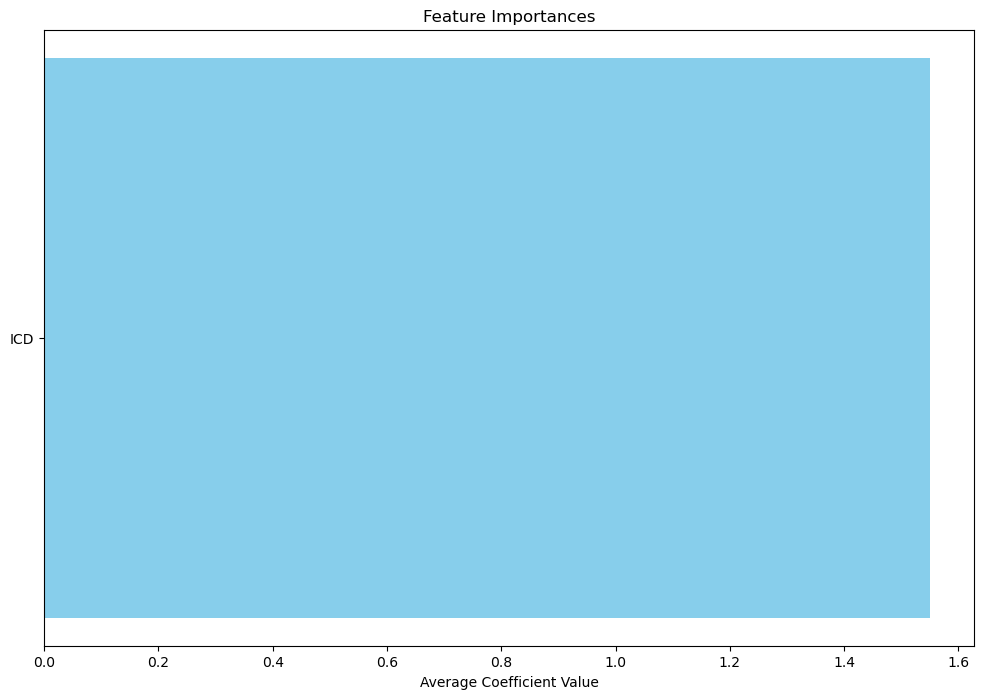

<Figure size 640x480 with 0 Axes>

In [6]:
# Aggregate feature importances by averaging over folds
avg_feature_importances = {feature: np.mean(importances) for feature, importances in feature_importances_dict.items()}
sorted_features = sorted(avg_feature_importances.items(), key=lambda item: item[1], reverse=True)
features, importances = zip(*sorted_features)

# Create a DataFrame of feature importances
feature_importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
})

# Save the DataFrame to a CSV file
feature_importance_df.to_csv('/home/jsearle/bigDrive/NAX/NLP-SAH_identification/model/results/ICD_only_BI_MGB/feat_importances.csv', index=False)

# Select top 10 and bottom 10 features
top_features = features[:10]
top_importances = importances[:10]
bottom_features = features[-10:]
bottom_importances = importances[-10:]

# Combine top and bottom features for plotting
plot_features = top_features + bottom_features
plot_importances = top_importances + bottom_importances

# Plot feature importances
plt.figure(figsize=(12, 8))
plt.barh(plot_features, plot_importances, color='skyblue')
plt.xlabel('Average Coefficient Value')
plt.title('Feature Importances')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature on top
plt.show()

plt.savefig('/home/jsearle/bigDrive/NAX/NLP-SAH_identification/model/results/ICD_only_BI_MGB/feat_importances.png')

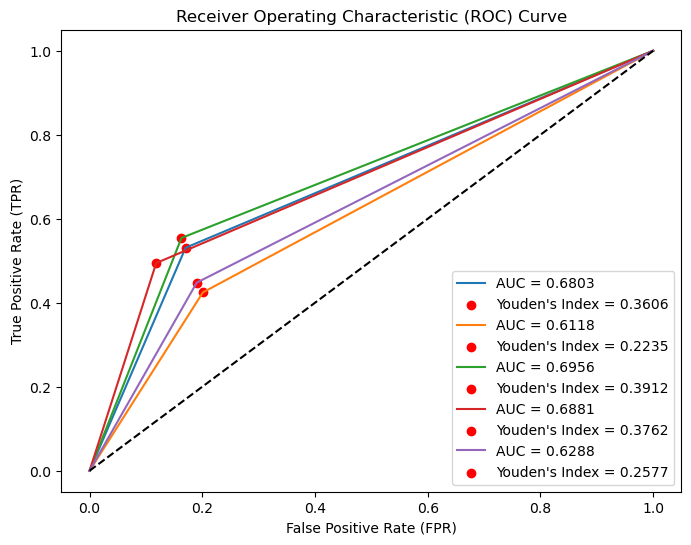

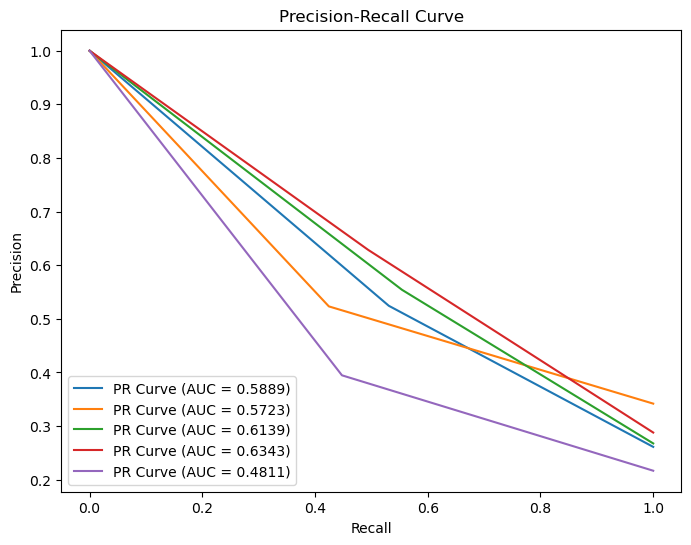

0.6609206456852965
0.0


In [7]:
# Plot all ROC curves overlayed on a single graph
plt.figure(figsize=(8, 6))
for fpr, tpr, auc_score in roc_curves:
    plt.plot(fpr, tpr, label='AUC = {:.4f}'.format(auc_score))
    youden = np.max(tpr-fpr)
    plt.scatter(fpr[np.argmax(tpr-fpr)], tpr[np.argmax(tpr-fpr)], c='red', label=f'Youden\'s Index = {youden:.4f}')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line representing random classifier
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.savefig('/home/jsearle/bigDrive/NAX/NLP-SAH_identification/model/results/ICD_only_BI_MGB/AUC_iter.png')
plt.show()

# Plot all PR curves overlayed on a single graph
plt.figure(figsize=(8, 6))
for recall, precision, auc_pr_loop in pr_curves:
    plt.plot(recall, precision, label='PR Curve (AUC = {:.4f})'.format(auc_pr_loop))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.savefig('/home/jsearle/bigDrive/NAX/NLP-SAH_identification/model/results/ICD_only_BI_MGB/PR_iter.png')
plt.show()


# Create a DataFrame to hold the results
results_df = pd.DataFrame({'Unnamed: 0': all_row_numbers, 'annot': all_true_labels, 'prediction': all_predictions})

# Save the DataFrame to a CSV file
results_df.to_csv('/home/jsearle/bigDrive/NAX/NLP-SAH_identification/model/results/ICD_only_BI_MGB/LR_iter_pred_rr.csv', index=False)

# Calculate the final AUC and F1
auc_final = np.mean(auc_cv)
f1_final = np.mean(f1_cv)

# Save all the data
df = pd.DataFrame()
df['auc'] = auc_cv
df['f1s'] = f1_cv
df['auc_pr'] = auc_pr
df['C'] = final_Cs
df['l1_ratio'] = final_l1
df_pred = pd.DataFrame()
df1 = pd.DataFrame(predictions[0])
df2 = pd.DataFrame(predictions[1])
df3 = pd.DataFrame(predictions[2])
df4 = pd.DataFrame(predictions[3])
df5 = pd.DataFrame(predictions[4])
df_pred = pd.concat([df1,df2,df3,df4,df5]).reset_index()
df.to_csv('/home/jsearle/bigDrive/NAX/NLP-SAH_identification/model/results/ICD_only_BI_MGB/LR_iter.csv')

# Print final Data
print(auc_final)
print(f1_final)

In [10]:
print(final_Cs)
print(final_l1)

[0.916033953241182, 0.27600803518043576, 0.5207966205058764, 1.0899750168901192, 0.4118395394128714]
[0.04804382394135285, 0.01, 0.01, 0.9833232816435636, 0.01]
